### Creating an image classifier able to find sneakers in instagram posts

The data comprises of few thousand images of sneakers collected using google images and instagram
and few thousand images of sneakers.    
Your goal is to use what you learned from previous examples and create a sneaker-not-sneaker binary classifier.

The task comprises of multiple sub-tasks that you need to do to build the classifier.

1. Create a dataset able to load data from new_meta_sneakers.csv
2. Create a fine tune binary classification architecture.
3. Create a training loop and train your model.

![title](sneakers.png)


### On the bottom of the following cell you see the data you will work with

In [43]:
%matplotlib inline
from torch import nn
import easyimages
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from pretrainedmodels.models import resnet50
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score

import matplotlib.pyplot as plt
import torch 
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


In [44]:
DATASET_USAGE_PERCENTAGE = 1

base_path ='/media/i008/ssd500/fashion_classify_data/'
df = pd.read_csv(os.path.join(base_path,'new_meta_sneakers.csv')).sample(frac=1)
df.image_path = base_path +df.image_path
df.tags = df.tags.map({'sneakers': 1, 'negatives': 0})
df = df.sample(frac=DATASET_USAGE_PERCENTAGE)


### Creating the torch Dataset.

First thing we need to do is create a dataset able to load our data. Since our metadata is stored in a csv file, our 
dataset should accept this file as a base source of what needs to be loaded.

Our dataset should also support augumentations and a "inference" mode wich disables them for predicting.


In [45]:
import PIL
from PIL import Image
import io
import requests
import torch
from torch.utils.data import Sampler


class OneClassImageClassificationDataset(Dataset):
    def __init__(self, annotations, image_transform):
        """
        annotations is a pandas dataframe
        
        """
        super().__init__()
        self.annotations = annotations
        self.image_transform = image_transform

    def __len__(self):
        """
        Return the length of the annotations dataframe
        """
        # your code here
        return len(self.annotations)

    def __getitem__(self, index):
        """
        Using methods you wrote:
        1 - load image from disk for given index  (self.load_from_disk)
        2 - transform image (self.image_transform)
        3 - Load target (self.load_target)
        return Xi, yi
        """
        
        # YOUR CODE HERE

        Xi = self.load_from_disk(index)
        Xi = self.image_transform(Xi)
        yi = self.load_target(index)
        return Xi, yi

    def load_to_pil(self, uri):
        """
        Write a helper function that uses PIL.Image to load a file and returns it
        """

        image_pil = Image.open(uri)
        image_pil = image_pil.convert("RGB")
        # image_pil = YOUR CODE HERE
        return image_pil


    def load_from_disk(self, index):
        """
        Loads an image from disk given a index.
        It gets the path of an image with the corresponding index from the metadata 
        It passes the URI to the self.load_to_pil and returns a PIL.Image
        """
        image_path = self.annotations.iloc[index]['image_path']
        #image_path = # YOUR CODE HERE
        return self.load_to_pil(image_path)

    def load_target(self, index):
        """
        This function should get the tag for a given index from the annotations dataframe
        You .iloc can become useful.    
        This methods should return, either a 0 or a 1.
        """
        
        #label = # YOUR CODE HERE
        label = self.annotations.iloc[index]['tags']

        return label
    
    
class BaseSampler(Sampler):
    def __init__(self, df, n_samples):
        self.df = df
        self.n_samples = n_samples
        
    def __iter__(self):
        return iter(self._get_sample())
        
    def __len__(self):
        return self.n_samples
    
    def _get_sample(self):
        return np.random.choice(len(self.df), self.n_samples, replace=False)
        

def binary_classification_model():
    """
    Write a function that loads a resnet50 model from pretrainedmodels, freezes its layers
    replaces the last_linear with the proper output number. As we did in previous example.
    replace avgpool with adaptiv pooling.
    """
    model = resnet50()
    for p in model.parameters():
        p.requires_grad = False
    inft = model.last_linear.in_features
    model.last_linear = nn.Linear(in_features=inft, out_features=2)
    model.avgpool = nn.AdaptiveAvgPool2d(1)
    
    # model = YOUR CODE HERE
    return model


from imgaug import augmenters as iaa

aug_seq = iaa.Sequential([
    iaa.Fliplr(p=0.5),
    iaa.Sometimes(
        0.3,
        iaa.Multiply((0.9, 1.2))
    ),
    iaa.Sometimes(
        0.3,
        iaa.AdditiveGaussianNoise()
    ),
    iaa.Affine(
        scale=(0.5, 2),
        translate_percent=(-0.2, 0.2)
    )
])
def augment(self, augmenter, image):
    augmenter = augmenter.to_deterministic()
    img_aug = augmenter.augment_image(np.array(image))
    img_aug = Image.fromarray(img_aug)
    return img_aug

In [47]:

# YOUR CODE HERE:
# SPLIT the dataframe into df_train, df_test (thing about using sklearn.model_selection.train_test_split)
df_train, df_test = train_test_split(df, train_size=0.8)
df_train = df_train.reset_index()
df_test = df_test.reset_index()

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
N_EPOCHS = 10
BATCH_SIZE = 32
IMAGE_SIZE = 224

image_transform_train = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)])

# YOUR CODE define image_transform_test
image_transform_test = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)])

# YOUR CODE define the crieterion
criterion = nn.CrossEntropyLoss()

net = binary_classification_model()

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)


# YOUR CODE
# Instantiate the OneClassImageClassificationDatasets
train_ds = OneClassImageClassificationDataset(df_train, image_transform=image_transform_train)
test_ds = OneClassImageClassificationDataset(df_test, image_transform=image_transform_test)

# initialize the BaseSampler
bs = BaseSampler(train_ds, 500)

#YOUR CODE
#Initialize your DataLoader (using datasets)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=bs)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

/home/i008/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [48]:
import numpy as np 
def evaluate_model(model, loader, print_info=False):
    with torch.no_grad():
        model.eval()
        collect_results = []
        collect_target = []
        for batch in loader:
            X, y = batch
            X = X.to(DEVICE)
            y = y.to(DEVICE).detach().cpu().numpy()
            pred = model(X)
            collect_results.append(pred.sigmoid().detach().cpu().numpy())
            collect_target.append(y) 
    
        preds_proba = np.concatenate(collect_results)
        preds = preds_proba.argmax(axis=1)
        
        targets = np.concatenate(collect_target)
        
        ll = log_loss(targets, preds_proba)
        acc = accuracy_score(targets, preds)
        if print_info:
            print("test log-loss: {}".format(ll))
            print("overall accuracy:  {}".format(acc))
            #print(classification_report(targets, preds))
        model.train()
        
        return ll, acc
    
metrics = []
metrics_names = ['loss_train','loss_test','acc_train','acc_test']
losses = []

net.to(DEVICE)

for epoch in range(N_EPOCHS):
    for X, y in train_dl:
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        optimizer.zero_grad()
        ypred=net(X)
        loss = criterion(ypred, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
        
    testll, testacc = evaluate_model(net, test_dl)
    trainll, trainacc = evaluate_model(net, train_dl)
    print("test: {} {}".format(testll, testacc))
    print("train: {} {}".format(trainll, trainacc))
    metrics.append([trainll, testll, trainacc, testacc])
        

/home/i008/anaconda3/lib/python3.6/site-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


test: 0.5048504588552152 0.8273246055723397
train: 0.516587948128581 0.808
test: 0.4677797295699617 0.8280631084256462
train: 0.45979013369977473 0.848
test: 0.4480824895121205 0.8365894595501846
train: 0.4403573891334236 0.854
test: 0.4388743495431702 0.8345753608593488
train: 0.4300677116326988 0.844
test: 0.4336881693537632 0.8368580060422961
train: 0.46539418802037835 0.816
test: 0.42907476461660987 0.8424303457536086
train: 0.42098932246118786 0.842
test: 0.4196331403045951 0.8515609264853978
train: 0.3952502954900265 0.876
test: 0.4096265235744459 0.8537092984222894
train: 0.4060871259719133 0.836
test: 0.43704661320386623 0.8172541121181605
train: 0.479952493943274 0.794
test: 0.40085864068478216 0.8562604900973481
train: 0.3953309319503605 0.85


In [14]:
import pathlib 

In [31]:
import pathlib 

base = pathlib.Path(base_path)
sneakers_path = base / 'sneakers'
negatives_path = base/ 'negatives'
sneakers = [str(a) for a in sneakers_path.glob('*')]
negatives = [str(a) for a in negatives_path.glob('*')]
ones = [1] * len(sneakers)
zeros = [0] * len(negatives)
df = pd.DataFrame()
df['image_path'] = sneakers + negatives
df['tags'] = ones + zeros

failed_ix = []
for i, image_path in enumerate(df.image_path):
    try:
        PIL.Image.open(image_path)
    except:
        print("Faield opening")
        failed_ix.append(i)
        
print('missing files:')
df.iloc[failed_ix]
df = df.drop(failed_ix)

Faield opening
Faield opening
Faield opening
Faield opening


In [33]:
df.drop(failed_ix).shape

(74601, 2)

In [34]:
print(df.shape)

(74605, 2)


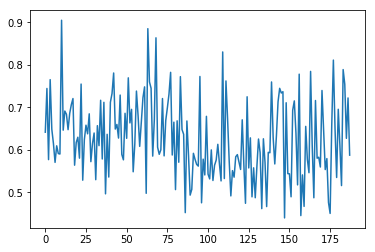

In [42]:
plt.plot(losses)

In [51]:
g = iter(train_dl)

In [53]:
%timeit next(g)

673 ms ± 37.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [112]:
train_dl1 = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=bs, num_workers=0)
train_dl16 = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=bs, num_workers=8)


In [123]:
g = iter(train_dl16)

In [130]:
import time
t0 = time.time()
next(g)
print(time.time() - t0)

0.0018208026885986328


In [67]:
t0 = 
next(g)

[tensor([[[[ 1.7009,  1.7009,  1.7009,  ...,  1.6153,  1.6324,  1.6324],
           [ 1.7180,  1.7009,  1.7009,  ...,  1.6153,  1.6324,  1.6324],
           [ 1.7009,  1.7009,  1.7009,  ...,  1.6153,  1.6324,  1.6324],
           ...,
           [ 0.8104,  0.8104,  0.8104,  ...,  0.0056, -0.0458, -0.0972],
           [ 0.7591,  0.7762,  0.7762,  ..., -0.0287, -0.0801, -0.1314],
           [ 0.7419,  0.7591,  0.7591,  ..., -0.0972, -0.1314, -0.1657]],
 
          [[ 1.8508,  1.8508,  1.8508,  ...,  1.7633,  1.7808,  1.7808],
           [ 1.8683,  1.8508,  1.8508,  ...,  1.7633,  1.7808,  1.7808],
           [ 1.8508,  1.8508,  1.8508,  ...,  1.7633,  1.7808,  1.7808],
           ...,
           [ 0.9405,  0.9405,  0.9580,  ..., -0.0224, -0.0749, -0.0749],
           [ 0.9055,  0.9230,  0.9230,  ..., -0.0574, -0.0924, -0.0924],
           [ 0.8880,  0.9055,  0.8880,  ..., -0.0749, -0.0924, -0.1275]],
 
          [[ 1.9951,  1.9951,  1.9951,  ...,  1.9080,  1.9254,  1.9254],
           [ 